In [56]:
from pymongo import MongoClient
import datetime
from dateutil import parser
import pandas as pd
from pytz import timezone

This notebook relies on a database of tweets.  By default, the database is running on the same computer where this code runs, so it is not necessary to specify the IP address of the DB.  Unless you have scraped tweets too, you will not be able to run this notebook.

In [57]:
# Initialize mongoDB client
client = MongoClient()
db = client.retweets

The `get_time_bins` function uses a histogram approach, iterating through each tweet and then counting it towards the appropriate bin.  This is faster than several other approaches that I tried.

In [58]:
def get_time_bins(collection):
    """
    Counts number of tweets in each hour in database.  Uses hours ending at :45 becuase that's when I collected data.
    """
    # Get first and last tweet, adjust to standard 45-minute window
    first_tweet = collection.find().sort('id', 1).limit(1).next()
    first = parser.parse(first_tweet['created_at'])
    first =  datetime.datetime(year=first.year, month=first.month, day=first.day, hour=first.hour, minute=45, tzinfo=first.tzinfo) - datetime.timedelta(hours=1)
    last_tweet = collection.find().sort('id', -1).limit(1).next()
    last = parser.parse(last_tweet['created_at'])
    last =  datetime.datetime(year=last.year, month=last.month, day=last.day, hour=last.hour, minute=45, tzinfo=last.tzinfo) + datetime.timedelta(hours=1)
    # now = datetime.datetime.now(timezone('UTC'))
    # now =  datetime.datetime(year=now.year, month=now.month, day=now.day, hour=now.hour, minute=45, tzinfo=now.tzinfo)

    # Build initial data for dataframe
    num_bins = int((last - first).total_seconds()/3600)
    bin_ends = first + pd.np.arange(1, num_bins+1)*datetime.timedelta(hours=1)
    init_df = [(be, be, 0) for be in bin_ends]
    df = pd.DataFrame(init_df, columns=['first_time', 'end', 'bin_count'])

    # Place tweets into bins
    for tweet in collection.find():
        tweet_time = parser.parse(tweet['created_at']) # parse tweet time
        binno = int((tweet_time - first).total_seconds()/3600) #binno is number of hours since first bin start
        if binno < 0:
            continue
        df.set_value(binno, 'bin_count', df.bin_count[binno]+1)
        if tweet_time < df.iloc[binno].first_time:
            df.set_value(binno, 'first_time', tweet_time)
    df = df[df.bin_count != 0]
    
    
    rates = df['bin_count']/((df['end'] - df['first_time'])/pd.np.timedelta64(1, 's'))*3600
    df['rate'] = rates
    
    return df

Calculate tweet-time histogram for a single user

In [109]:
user = '@donlemon' # note: database names are case sensitive
reponame = user[1:] + '_tweetsat' # naming convention for tweets mentioning user
collection = db[reponame]
#collection.find({'id': {'$gt': begin_id}}).sort('id', 1).limit(100).next()['created_at'] # test
bins_df = get_time_bins(collection)
bins_df.head()

,first_time,end,bin_count,rate
0,2016-08-30 12:24:59+00:00,2016-08-30 12:45:00+00:00,59,176.852623
1,2016-08-30 12:45:00+00:00,2016-08-30 13:45:00+00:00,252,252.000000
2,2016-08-30 13:45:18+00:00,2016-08-30 14:45:00+00:00,167,167.839196
3,2016-08-30 14:45:27+00:00,2016-08-30 15:45:00+00:00,101,101.763224
4,2016-08-30 15:45:40+00:00,2016-08-30 16:45:00+00:00,80,80.898876


Convert tweet counts to rates (tweets/hour)

Produce a plot of tweet rate over time.

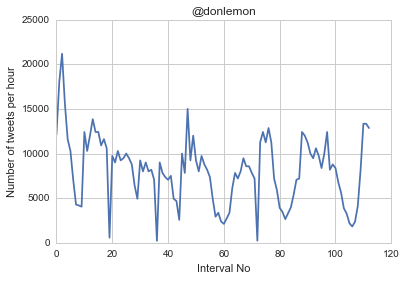

In [110]:
# Plot the rate over time
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(rates)), rates)

plt.xlabel('Interval No')
plt.ylabel('Number of tweets per hour')
plt.title(user)
plt.show()

Aggregate the estimates for each hour on weekdays.  This provides an estimate for the tweet rate for a set of interesting times.

In [111]:
def get_hour_rates_weekdays(bins_df):
    # Initialize rate dataframe
    hour_rates_df = pd.DataFrame([(0.0,0,'%d:45'%i) for i in range(24)], columns=['total', 'n', 'hour'])

    # Add up measurements for each time
    for row in bins_df.iterrows():
        time_end = row[1]['end'].astimezone(timezone('US/Eastern'))
        if time_end.weekday() < 5: # saturday5, sunday6 (monday0)
            hour = time_end.hour
            hour_rates_df.set_value(hour, 'total', hour_rates_df.ix[hour, 'total'] + row[1]['rate'])
            hour_rates_df.set_value(hour, 'n', hour_rates_df.ix[hour, 'n'] + 1)
    # Calculate average rate for each time
    hour_rates_df['rate'] = hour_rates_df['total']/hour_rates_df['n']
    hour_rates_df.fillna(0, inplace=True)
    
    return hour_rates_df
tweetsat_hour_rates = get_hour_rates_weekdays(bins_df)
tweetsat_hour_rates['percent'] = tweetsat_hour_rates['rate']/tweetsat_hour_rates['rate'].sum()*100
tweetsat_hour_rates.head()

,total,n,hour,rate,percent
0,664.729712,5,0:45,132.945942,7.115483
1,430.211277,5,1:45,86.042255,4.605121
2,213.143872,4,2:45,53.285968,2.851952
3,177.565711,4,3:45,44.391428,2.375901
4,121.491695,4,4:45,30.372924,1.625608


Compute the rates for user tweets

In [112]:
reponame = user[1:] + '_tweets' # naming convention for tweets mentioning user
collection = db[reponame]
#collection.find({'id': {'$gt': begin_id}}).sort('id', 1).limit(100).next()['created_at'] # test
tweets_bins_df = get_time_bins(collection)
tweets_hour_rates = get_hour_rates_weekdays(tweets_bins_df)
tweets_hour_rates['percent'] = tweets_hour_rates['rate']/tweets_hour_rates['rate'].sum()*100
tweets_hour_rates.head()

,total,n,hour,rate,percent
0,337.254430,57,0:45,5.916744,3.119949
1,388.869168,47,1:45,8.273812,4.362851
2,72.064533,21,2:45,3.431644,1.809535
3,16.875416,6,3:45,2.812569,1.483091
4,1.100244,1,4:45,1.100244,0.580168


In [113]:
all_hour_rates = tweetsat_hour_rates[['hour']].copy()
all_hour_rates['tweets_rate'] = tweets_hour_rates['rate']
all_hour_rates['tweetsat_rate'] = tweetsat_hour_rates['rate']
all_hour_rates['ratio'] = tweets_hour_rates['rate']/tweetsat_hour_rates['rate']
all_hour_rates.head()

,hour,tweets_rate,tweetsat_rate,ratio
0,0:45,5.916744,132.945942,0.044505
1,1:45,8.273812,86.042255,0.096160
2,2:45,3.431644,53.285968,0.064401
3,3:45,2.812569,44.391428,0.063358
4,4:45,1.100244,30.372924,0.036225


Plot the results as a horizontal bar chart.

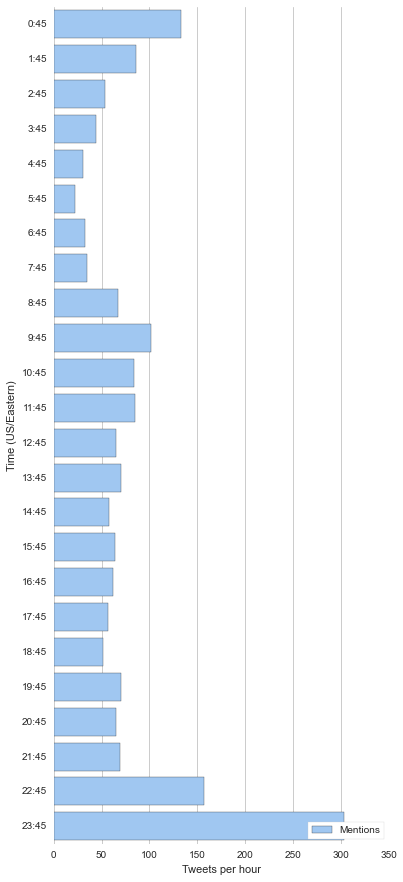

In [114]:
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="rate", y="hour", data=tweetsat_hour_rates,
            label="Mentions", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Time (US/Eastern)", xlabel="Tweets per hour")
sns.despine(left=True, bottom=True)

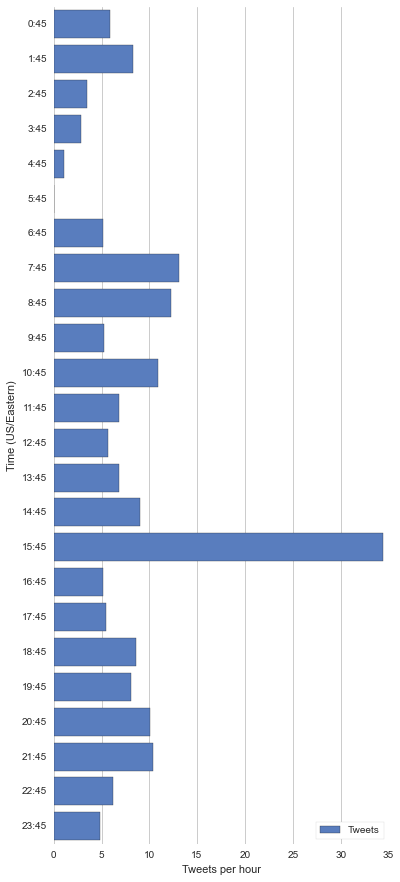

In [115]:
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="rate", y="hour", data=tweets_hour_rates,
            label="Tweets", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Time (US/Eastern)", xlabel="Tweets per hour")
sns.despine(left=True, bottom=True)

### Determining the best time of day to tweet
Being a reporter is a job, and many jobs have distinct hours.  I wanted to see whether reporters tend to tweet at a particular time of day, and whether that differs from when people mention them in tweets.  If so, one of the easiest ways to optimize your chance of a retweet is to user twitter when the reporters are on, and regular people are not.  For don lemon, the best times seem to be 3:45 PM and 7:45 AM.

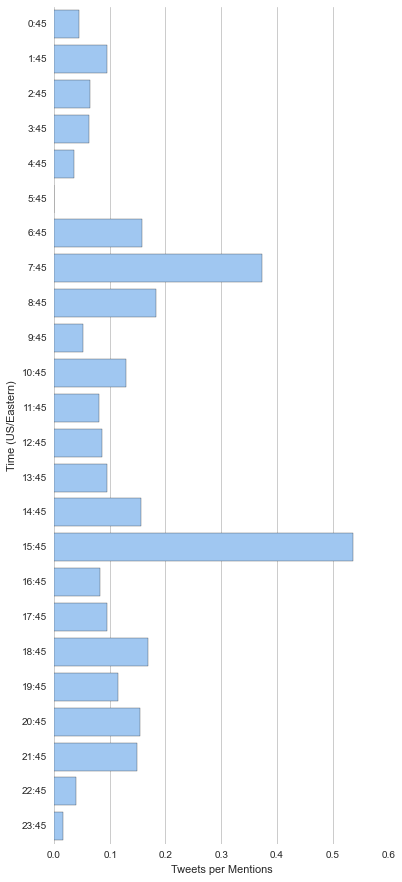

In [118]:
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="ratio", y="hour", data=all_hour_rates, color="b")


# Add a legend and informative axis label
ax.set(ylabel="Time (US/Eastern)", xlabel="Tweets per Mentions")
sns.despine(left=True, bottom=True)